## Cash Bond Flow Time Series Analysis 
##### -- An Intern Project by Zhiwei Hu @ Standard Chartered Bank China Shanghai
---
### First Time User
** Please make sure you changed them into your own path 确保以下两处改成了自己的路径**
![Path 1](Path1.PNG)
![Path 2](Path2.PNG)


### **Updating Methods -- Daily**
1. Drag the New CFETS Daily data Excel into the folder where this python code exists.

![Step 1](Move_New_File.PNG)

2. Updating the CGB Yield Data in Wind, and download the file into the same folder. The start date could be set as 2019-01-01, and don't tick the "Frequency" when exporting the Excel file.

![Step 2](Download_from_Wind.PNG)
---
### **Weekly/Biweekly Index Update**
When calculating the risk change, the program uses bond index duration to approximate the duration of bond flow change by every institution. However, the index duration does not change so frequently so this update could be conducted on a weekly or even biweekly basis.
The indices used are:
* CBA00211.CS 
* CBA00221.CS
* CBA00231.CS
* CBA00241.CS
* CBA00251.CS
* CBA00261.CS

Simply go to the index  page in wind ——> F9 ——> 指数特征 ——> 风险分析, the start date could be set as 2021-01-01, and the end date is up to today. The frequency is DAILY data. Save the file into the folder, no need to make any change.

![Step 3](Import_Index_data.PNG)

### Run the Program
Cell ——> Run All, and until you see this, it means all data are ready and you choose combine any variables in the execution block to draw the time-series.

![Until You See This](All_Month_Data.PNG)


In [6]:
# Import Libraries
import pandas as pd
import numpy as np
import datetime as dt
import re
from IPython.core.display import display
import os
import errno
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Create separated paths for better organizing
today = str(dt.date.today())
def path_exists_handle(path):
    try:
        os.mkdir(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def mk_dir(name):
    directory = today
    parent_dir = r'C:\Users\Zhiwei Hu\Desktop\Cash Bond Analysis New\Cash Bond Flow Analysis' # 在这里改路径1
    path = os.path.join(parent_dir,directory)
    path_exists_handle(path)

    path = os.path.join(path,name)
    path_exists_handle(path)
    return path

In [8]:
# Data cleaner
def clean_data(data):
    data.replace(to_replace = '—',value=0, inplace=True)
    data.replace(to_replace = '---',value=0, inplace=True)
    data.set_index('期限',inplace=True)
    for column in data.columns:
        data[column] = data[column].astype(str).astype(float)
    return data

# Split by Institutions
def Institution_spliter(example_file):
    
    ins_dict = {}
    Large_banks = example_file[:10]
    JointS_banks = example_file[10:20]
    Urban_banks = example_file[20:30]
    Foreign_banks = example_file[30:40]
    Rural_banks = example_file[40:50]
    Sec_company = example_file[50:60]
    Insurance = example_file[60:70]
    Funds = example_file[70:80]
    WM_S = example_file[80:90]
    Else = example_file[90:100]
    Foreign_ins = example_file[100:110]
    MMF = example_file[110:120]
    Others_ = example_file[120:130]
    
    ins_dict = {'Large Commercial and Policy Banks':Large_banks,'Joint Stock Commercial Banks':JointS_banks,
                'Urban Commercial Banks':Urban_banks,'Foreign Banks':Foreign_banks, 'Rural Financial Institutions':Rural_banks,
                'Securities Companies':Sec_company,'The Insurance Company':Insurance,'Fund Companies and Products':Funds,
                'WM Subs':WM_S,'Else Products':Else,'Foreign Institutions':Foreign_ins,'Money Market Fund':MMF,'Others':Others_}
    for key, value in ins_dict.items():
        ins_dict[key] = clean_data(value)
    return ins_dict

# interests Bonds Converter
def dataframe_converter(original_data, large_gradular=False):
    # Rename the Column Names
    interests_list = ['国债-新债\n（Treasury Bond On-the-Run）','国债-老债\n（Treasury Bond Off-the-Run）',
                      '政策性金融债-新债\n(Policy Financial Bond On-the-Run)',
                      '政策性金融债-老债\n(Policy Financial Bond Off-the-Run)',
                      '地方政府债\n（Local Goverment Bond）','同业存单\n（CDs）','中期票据\n（Medium-term Note）',
                     '短期/超短期融资券\n(Short-term Commercial Paper)','企业债\n（Corporate Bond）',
                      '资产支持证券\n（Asset-bakced Security）','其他\n（Others）','合计\n(Total)']
    interests_bonds = original_data[interests_list]
    new_columns = ['CGB On-the-Run','CGB Off-the-Run','PFB On-the-Run','PFB Off-the-Run','LGB','CDs','MTN','SCP',
                   'Corporate Bond','ABS','Others','Total']
    new_rows = ['<1Y','1~3Y','3~5Y','5~7Y','7~10Y','10~15Y','15~20Y','20~30Y','>30Y']
    interests_bonds.columns = new_columns
    interests_bonds = interests_bonds.transpose()
    interests_bonds = interests_bonds.iloc[:,:-1]
    interests_bonds.columns = new_rows
    interests_bonds['>10Y']=interests_bonds.iloc[:,-4:].sum(axis=1)
    interests_bonds.drop(['10~15Y','15~20Y','20~30Y','>30Y'], axis=1, inplace=True)
    if large_gradular == False:
        return interests_bonds
    else:
        return large_gradular_(interests_bonds)

# Combine the On-the-Run and Off-the-Run CGB and PFB
def large_gradular_(original_data):
    # this function is used to combine on-the-run and off-the-run bonds
    original_data_ = original_data.transpose()
    original_data = original_data.apply(pd.to_numeric)
    original_data_['CGB'] = original_data_.iloc[:,0:2].sum(axis=1)
    original_data_['PFB'] = original_data_.iloc[:,2:4].sum(axis=1)
    original_data_['CGB+PFB'] = original_data_['CGB']+original_data_['PFB']
    original_data_.drop(['CGB On-the-Run','CGB Off-the-Run','PFB On-the-Run','PFB Off-the-Run'],axis=1,inplace=True)
    return original_data_.transpose()

# Convert to time-series data
def time_series_merger(institution_type, bond_type, maturity):
    data = institution_type
    result_dict = {}
    result = pd.DataFrame()
    for key, value in data.items():
        value = value.transpose()
        if maturity:
            slice_ = value.loc[maturity,bond_type]
            result_dict[key] = slice_
        else:
            slice_ = value[bond_type]
            result[key] = slice_
    if maturity:
        result = pd.DataFrame.from_dict(result_dict,orient='index')
        result.columns=[maturity]
        return result #transpose if else
    else:
        return result.transpose()

# To draw the stacked cash flow trading time series
def draw_cash_bond_time_series(institution_type, bond_type='Total', start_date='2021-06-01',name=None,maturity=None,
                               accumulative=False,weekly_resample=True):
    plot_data = time_series_merger(institution_type,bond_type,maturity)
    plot_data.index = pd.to_datetime(plot_data.index,format='%Y-%m-%d')
    if weekly_resample == True:
        plot_data = plot_data.resample('1W').sum()
    if accumulative == True:
        plot_data = plot_data.cumsum()
    title_ = bond_type+" Bond Net Position Time Series by "+name
    parent_path = mk_dir('Cash Bond Time Series')
    # plot
    fig,ax=plt.subplots()

    if maturity:
        plot = plot_data.loc[start_date:].plot(figsize=(16,9),kind='bar',title=title_, ax=ax)
        ax.set_xticklabels([x.strftime('%m-%d') for x in plot_data.loc[start_date:].index])
        if maturity == '<1Y':
            new_path = 'Cash Bond Time Series '+'小于1Y'
        elif maturity == '>10Y':
            new_path = 'Cash Bond Time Series '+'大于10Y'
        else:
            new_path = 'Cash Bond Time Series '+maturity
        parent_path = mk_dir(new_path)
    else:
        plot = plot_data.loc[start_date:].plot(figsize=(16,9),kind='bar',stacked=True,title=title_,ax=ax)
        ax.set_xticklabels([x.strftime('%m-%d') for x in plot_data.loc[start_date:].index])

    fig = plot.get_figure()
    sub_path = 'Time Series of '+name+' '+bond_type+'.png'
    path = os.path.join(parent_path,sub_path)
    fig.savefig(path)
    plt.show()

# Calculate the daily tenor change
def cal_dly_tnr_chg(daily_data):
    # The daily data is the daily dataframe of the specific institution
    total_data = daily_data.transpose()[['Total']]
    index_mean = sample_index_mean[['Tenor <1','Tenor 1~3','Tenor 3~5','Tenor 5~7','Tenor 7~10','Tenor >10']].tolist()
    index_duration = sample_index_mean[['Duration <1','Duration 1~3','Duration 3~5','Duration 5~7','Duration 7~10','Duration >10']].tolist()
    index_mean_ = pd.Series(index_mean, index=total_data.index)
    index_duration_ = pd.Series(index_duration, index=total_data.index)
    result = pd.concat([total_data,index_mean_,index_duration_],axis=1)
    result.columns = ['Total','Tenor','Duration']
    result['Change'] = result.Total*result.Tenor
    result['Risk in USD K'] = 100000000*result.Total*result.Duration/6.48/10000/1000 
    abs_total = result['Total'].abs().sum()
    if abs_total != 0:
        final_result = ((result['Change'].sum())/(result['Total'].abs().sum()),result['Total'].sum(),result['Risk in USD K'].sum())
    else:
        final_result = (0,result['Total'].sum(),result['Risk in USD K'].sum())
    return final_result
    
# Merge the daily tenor change 
def tnr_time_series_merger(institution_type):
    data = institution_type
    result = {}
    for key, value in data.items():
        #value = value.apply(pd.to_numeric) # in case the data type error
        result[key] = cal_dly_tnr_chg(value)
    return result # The returned result is a tuple of weighted tenor change, the daily net position, and the daily risk change

# To draw the tenor change on daily basis
# Deprecated
def draw_tenor_change_daily(institution_type,start_date = '2021-06-01',name=None):
    institution_tenor = tnr_time_series_merger(institution_type)
    df = pd.DataFrame.from_dict(institution_tenor,orient='index')
    df.columns = ['Tenor Change']
    title_ = str('Tenor Change by ')+name
    plot_tnr = df.loc[start_date:].plot(figsize=(16,9),kind='line',title=title_)
    fig_tnr = plot_tnr.get_figure()
    fig_tnr.savefig(title_+'.png')
    plt.show()
    
# to draw the risk change on a daily basis
def draw_risk_change(institution_type,yield_data,start_date = '2021-06-01',name=None,weekly_resample=True):
    institution_tenor = tnr_time_series_merger(institution_type)
    df = pd.DataFrame.from_dict(institution_tenor,orient='index')[start_date:]
    df.columns = ['Tenor Change','Net Total','Risk_Change']
    title_ = str('Risk Change by ')+name+' in USD K'
    end_date = df.index[-1]
    risk_plot = pd.concat([df,yield_data[start_date:end_date]],axis=1)
    risk_plot.columns = ['Tenor Change','Net Total','Risk_Change','Yield']
    risk_plot.index = pd.to_datetime(risk_plot.index,format='%Y-%m-%d')

    if weekly_resample == True:
        risk_plot = risk_plot.resample('1W').agg({'Risk_Change':np.sum,'Yield':lambda x:x.iloc[-1]})

    ax = risk_plot.plot.bar(y='Risk_Change',figsize=(16,9),title=title_,alpha=0.75,rot=90)
    ax.set_xticklabels([x.strftime('%m-%d') for x in risk_plot.index])
    risk_plot.plot(y='Yield',secondary_y=True,ax=ax,color='g',use_index=False,legend=True,alpha=0.9,linewidth=5,rot=90)
    ax.right_ax.set_ylabel('10 Yr CGB Yield at Week-end')
    fig_tnr = ax.get_figure()
    parent_path = mk_dir('Risk Change')
    sub_path = title_+'.png'
    path = os.path.join(parent_path,sub_path)
    fig_tnr.savefig(path)
    plt.show()
    
# To draw tenor change with yield changes
def draw_tenor_with_yield(institution_name, start_date,yield_data, name=None, cumsum=False, pct_change=False, resample_weekly=True):
    # institution could be large_banks and so on
    start_date = start_date # set the start date
    institution_tenor = tnr_time_series_merger(institution_name)
    df = pd.DataFrame.from_dict(institution_tenor,orient='index')[start_date:]
    df.columns = ['Tenor Change','Net Total','Risk Change']
    end_date = df.index[-1]
    
    df_plot = pd.concat([df,yield_data[start_date:end_date]],axis=1)
    df_plot.columns = ['Tenor Change','Net Total','Risk Change','Yield']
    df_plot['Yield Pct Change'] = df_plot['Yield'].pct_change()
    df_plot.index = pd.to_datetime(df_plot.index,format='%Y-%m-%d')
    graph_kind = 'line'
    
    if cumsum == True:
        df_plot['Total Cumsum'] = df_plot['Net Total'].cumsum()
        df_plot['Weights'] = df_plot['Net Total']/df_plot['Total Cumsum']
        df_plot['Weighted Tenor'] = df_plot['Tenor Change']*df_plot['Weights']
        df_plot['Weighted Tenor CumSum'] = df_plot['Weighted Tenor'].cumsum()
        graph_kind = 'bar'

        if resample_weekly == True:
            df_plot = df_plot.resample('1W').agg({'Weighted Tenor CumSum':np.sum,'Yield':lambda x:x.iloc[-1]})
            df_plot['Yield Pct Change'] = df_plot['Yield'].pct_change()
    
    # plot
    title_=str('Tenor Change and CGB Yield Change by ')+name
    plot_cov = df_plot.plot(figsize=(16,9),y='Weighted Tenor CumSum',kind=graph_kind,title=title_,alpha=0.75,rot=90)
    if pct_change == True:
        ax = df_plot['Yield Pct'].plot(secondary_y = True,use_index=False,kind='line',color='g',legend=True,alpha=0.9,rot=90,linewidth=5)
        ax.set_xticklabels([x.strftime('%m-%d') for x in df_plot.index])
        ax.set_ylabel('10 Yr Gov Yield Percent Change')
    else:
        ax = df_plot['Yield'].plot(secondary_y = True,use_index=False,kind='line',color='g',legend=True,alpha=0.9,rot=90,linewidth=5)
        ax.set_xticklabels([x.strftime('%m-%d') for x in df_plot.index])
        ax.set_ylabel('10 Yr Gov Yield')
    fig = plot_cov.get_figure()
    parent_path = mk_dir('Tenor Change')
    sub_path = title_+'.png'
    path = os.path.join(parent_path,sub_path)
    fig.savefig(path)
    plt.show()


In [9]:
# Initiate the institution dictionaries
# Main Functions Below

large_banks = {}
JointS_banks = {}
Urban_banks = {}
Foreign_banks = {}
Rural_banks = {}
Sec_company = {}
Insurance = {}
Funds = {}
WM_S = {}
Else = {}
Foreign_ins = {}
MMF = {}
Others_ = {}

variables_list = [(large_banks,'Large Commercialand and Policy Banks'), (JointS_banks,'Joint Stock Commercial Banks'),
                  (Urban_banks,'Urban Commercial Banks'), (Foreign_banks,'Foreign Banks'), (Rural_banks,'Rural Financial Institutions'),
                  (Sec_company,'Securities Companies'), (Insurance,'The Insurance Company'),(Funds,'Fund Companies and Products'),
                  (WM_S,'Wealth Management Subsidiaries'), (Else,'Else Products'), (Foreign_ins,'Foreign Institutions'), (MMF,'Money Market Fund'),
                   (Others_,'Others')]

In [10]:
# Import the cash bond daily data
for i in range(1,13):
    for j in range(32):
        if j < 10:
            file_name = '20210'+str(i)+'0'+str(j)+'.xls'
        else:            
            file_name = '20210'+str(i)+str(j)+'.xls'
            
        try:
            # 在这里改自己的路径 2
            data_file = pd.read_excel(r'C:\Users\Zhiwei Hu\Desktop\Cash Bond Analysis New\Cash Bond Flow Analysis\现券市场交易情况总结日报_'+file_name,sheet_name=2, header = 4, index_col = 0)[:-1] # sheetname in older python versions
            tempt_dict = Institution_spliter(data_file)
            file_name = file_name[0:4]+'-'+file_name[4:6]+'-'+file_name[6:8]
            large_banks[file_name] = tempt_dict['Large Commercial and Policy Banks']
            JointS_banks[file_name] = tempt_dict['Joint Stock Commercial Banks']
            Urban_banks[file_name] = tempt_dict['Urban Commercial Banks']
            Foreign_banks[file_name] = tempt_dict['Foreign Banks']
            Rural_banks[file_name] = tempt_dict['Rural Financial Institutions']
            Sec_company[file_name] = tempt_dict['Securities Companies']
            Insurance[file_name] = tempt_dict['The Insurance Company']
            Funds[file_name] = tempt_dict['Fund Companies and Products']
            WM_S[file_name] = tempt_dict['WM Subs']
            Else[file_name] = tempt_dict['Else Products']
            Foreign_ins[file_name] = tempt_dict['Foreign Institutions']
            MMF[file_name] = tempt_dict['Money Market Fund']
            Others_[file_name] = tempt_dict['Others']
            
        except FileNotFoundError:
            None

    print('Read Month {0} Files Done...'.format(i))            
display(large_banks.keys())

# import the indicies data
index_data = pd.DataFrame()
for i in range(1,7):
    example_index = pd.read_excel(r'债券--指数特征--风险分析(CBA002'+str(i)+'1.CS).xls',index_col=0)[['剩余期限','久期(现金流法)']][:-1]
    index_data = pd.concat([index_data,example_index],axis=1)
new_index_columns = ['Tenor <1','Duration <1','Tenor 1~3','Duration 1~3','Tenor 3~5','Duration 3~5','Tenor 5~7','Duration 5~7',
                    'Tenor 7~10','Duration 7~10','Tenor >10','Duration >10']
index_data.columns = new_index_columns
sample_index_mean = index_data.loc[:'2021-03-01'].copy().mean(axis=0) # Set the start date here
print('\nIndices Data Import Done...')

Read Month 1 Files Done...
Read Month 2 Files Done...
Read Month 3 Files Done...
Read Month 4 Files Done...
Read Month 5 Files Done...
Read Month 6 Files Done...
Read Month 7 Files Done...
Read Month 8 Files Done...
Read Month 9 Files Done...
Read Month 10 Files Done...
Read Month 11 Files Done...
Read Month 12 Files Done...


dict_keys(['2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05', '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12', '2021-03-16', '2021-03-17', '2021-03-18', '2021-03-19', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01', '2021-04-02', '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-19', '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-25', '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30', '2021-05-06', '2021-05-07', '2021-05-08', '2021-05-10', '2021-05-11', '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-17', '2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21', '2021-05-24', '2021-05-25', '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-31', '2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04', '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-


Indices Data Import Done...


In [11]:
# sample plot of tenor change and CGB yield
import matplotlib.pyplot as plt
treasury_ = pd.read_excel(r'中债国债到期收益率(中债)(日).xls',header=0)[:-2]
treasury_['指标名称'] = treasury_['指标名称'].astype('str')
treasury_['指标名称'] = treasury_['指标名称'].apply(lambda x: x[:10])
treasury_.columns = ['Dates','Yield']
treasury_.set_index('Dates',inplace=True)
#treasury_['Yield Pct'] = treasury_['Yield'].pct_change()

print('Import 10 Yr CGB Yields Done...')

Import 10 Yr CGB Yields Done...


In [12]:
# Execute Dataframe Simplifier
for institution in variables_list:
    for key in institution[0].keys():
        institution[0][key] = dataframe_converter(institution[0][key],large_gradular=True)
        # Modify above to use larger gradular or not
        
print('Dataframe Simplifier Done!')

Dataframe Simplifier Done!




---
## Execution Block
### Parameters List for Query - For Any Combinations

|  Instution Variable   | Corresponding CN Name| Bond Type Variable | Corresponding CN Name | Maturity Variables | Corresponding CN Name|
|  ----               |---          |----        | ----| --- | ---|
| Large_banks  |  大行和政策性银行 | 'CGB' | 国债| '<1Y' | 小于1年
| JointS_banks  |   股份制银行 | 'PFB' | 政策性银行债| '1~3Y' | 1~3年
| Urban_banks  |   城商行 | 'CGB+PFB'| 国债+政策性银行债| '3~5Y'| 3~5年
| Foreign_banks  |   外资银行 | 'LGB' | 地方政府债 |'5~7Y' | 5~7年
| Rural_banks  |   农村金融机构 | 'CDs' | 存单 | '7~10Y'| 7~10年
| Sec_company  |   证券公司 | 'MTN' | 中票 | '>10Y'| 大于10年
| Insurance  |   保险公司 | 'SCP' | 短融 | (blank) | 所有期限
| Funds  |  公募基金及其产品 | 'Corporate Bond' | 企业债 | |
| WM_S  |  理财子 | 'ABS' | 资产支持债券| |
| Else  |  其它产品类 | 'Others' | 其它 | |
| Foreign_ins  |  外资机构 | 'Total' | 合计 | |
| MMF  |  货币市场基金 |  |
| Others_  |  其它 |  |

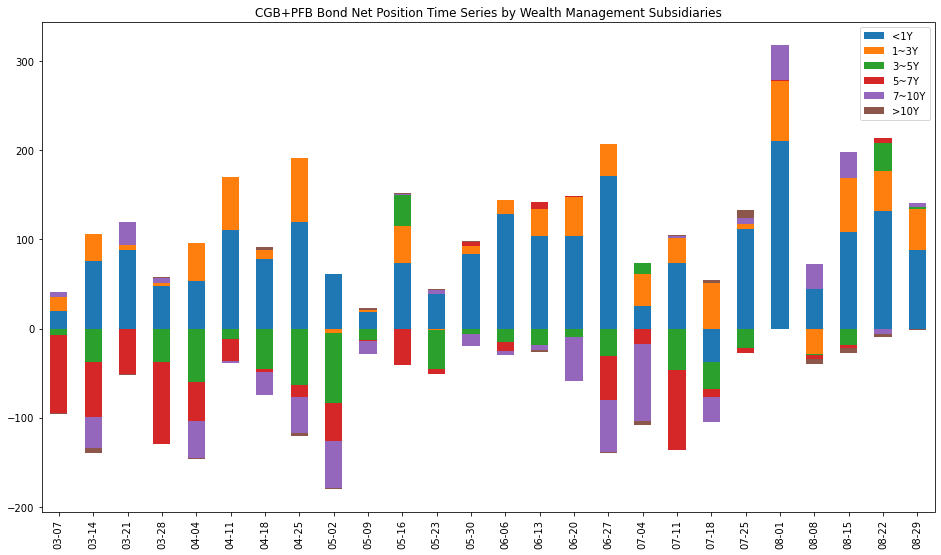

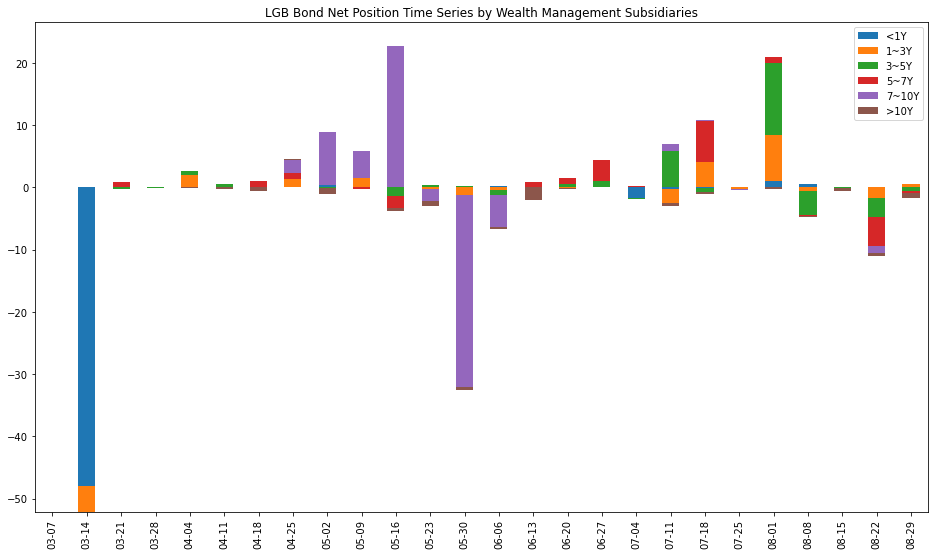

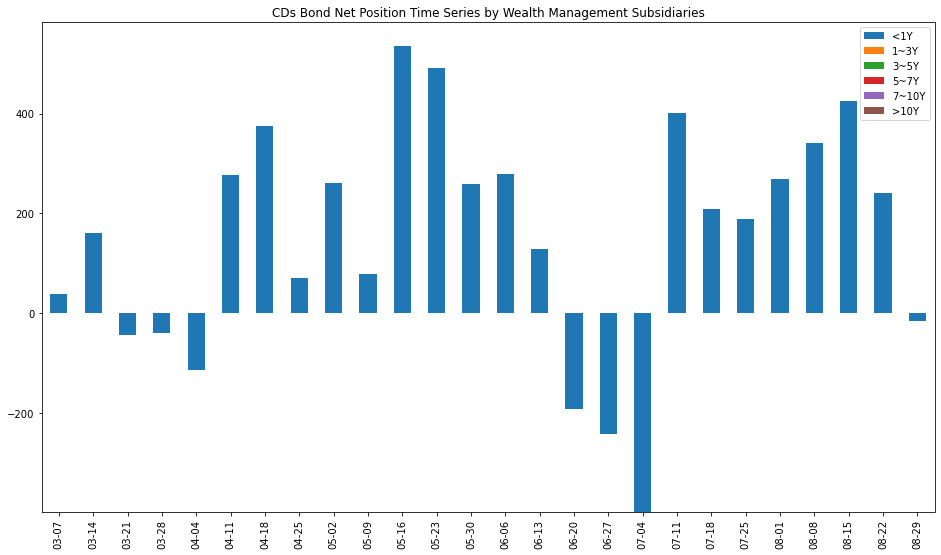

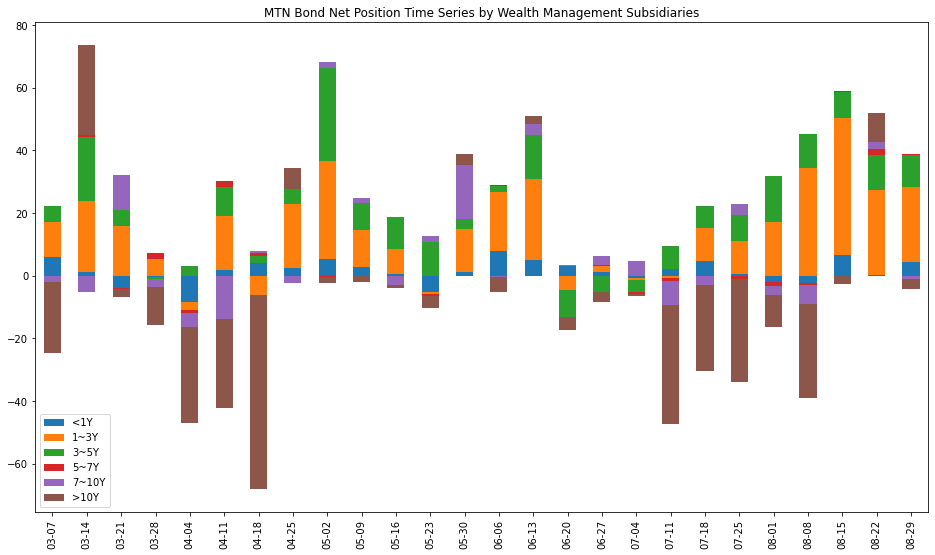

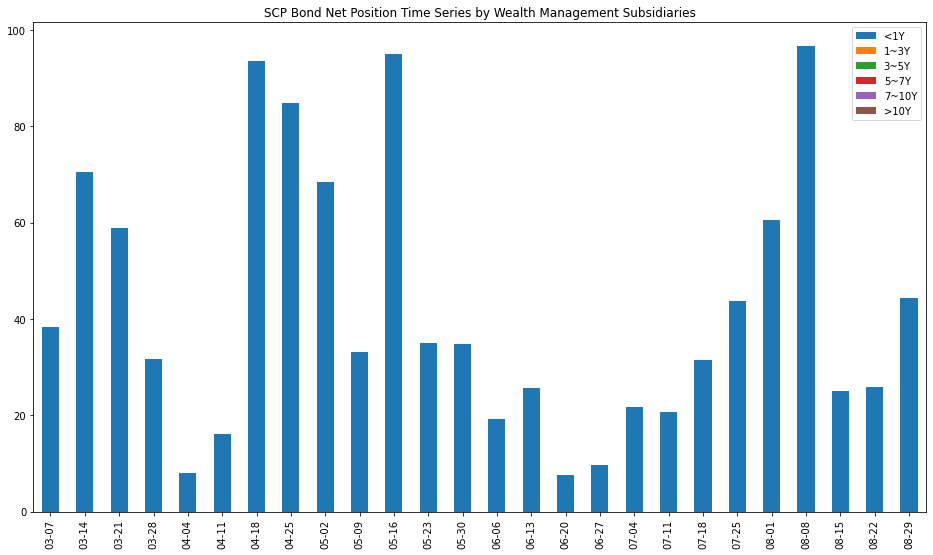

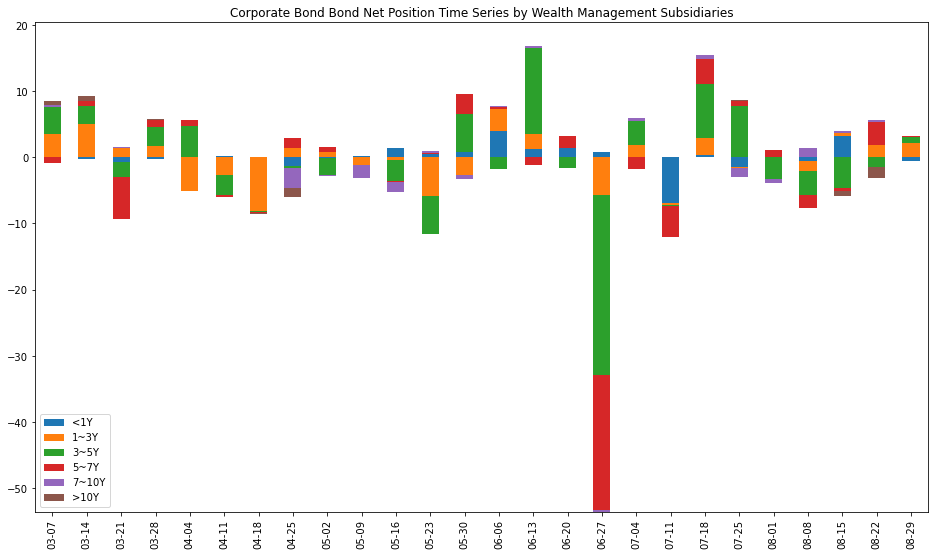

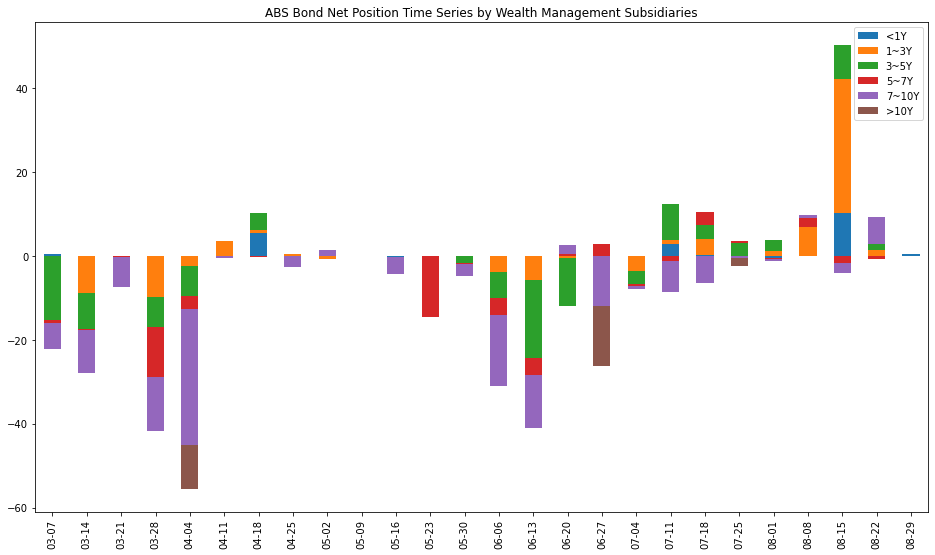

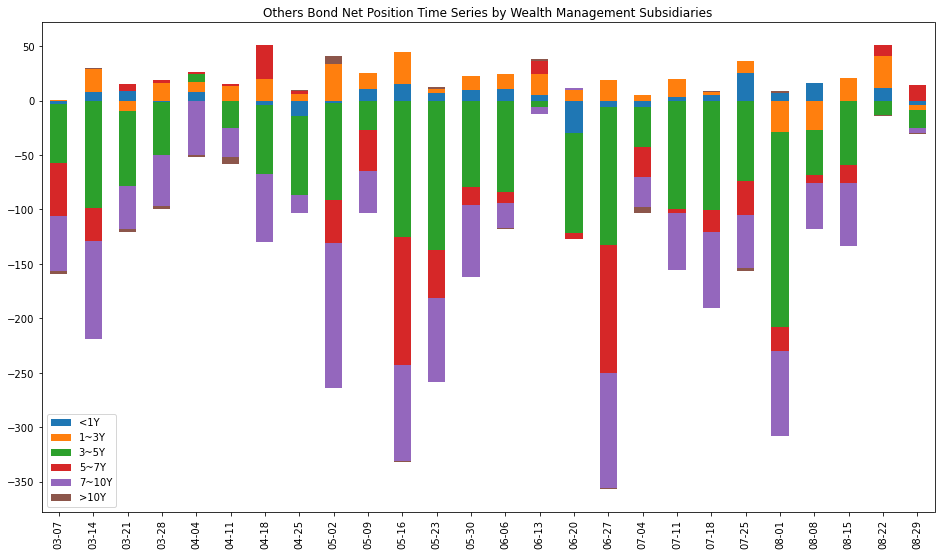

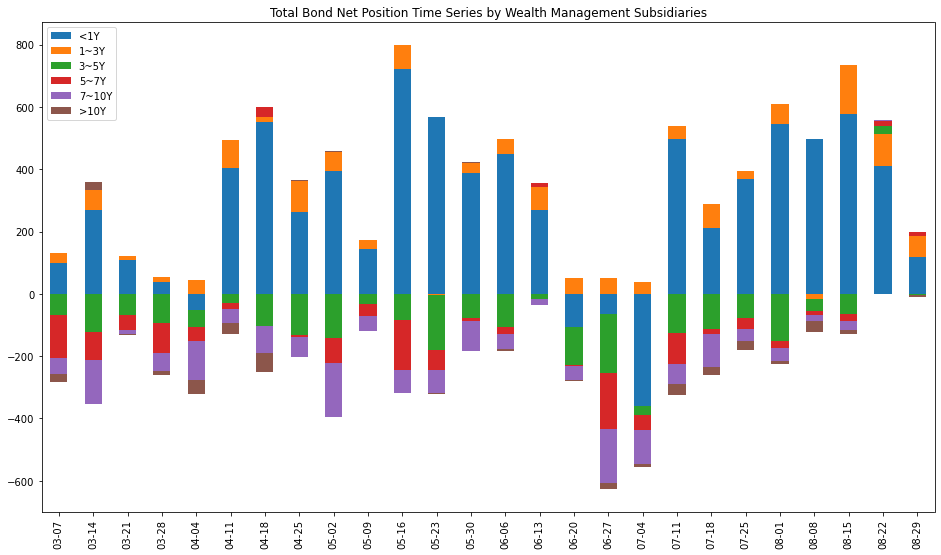

In [13]:
# The Execution Block
# Single Entity
type_list = ['CGB+PFB','LGB','CDs','MTN','SCP','Corporate Bond','ABS','Others','Total']
for bond_type in type_list:
    draw_cash_bond_time_series(WM_S, bond_type, start_date='2021-03-01',name='Wealth Management Subsidiaries', maturity = None,
                               accumulative=False,weekly_resample=True)
# The risk change
#draw_risk_change(JointS_banks, treasury_, start_date='2021-03-01',name='Sec',weekly_resample=True)

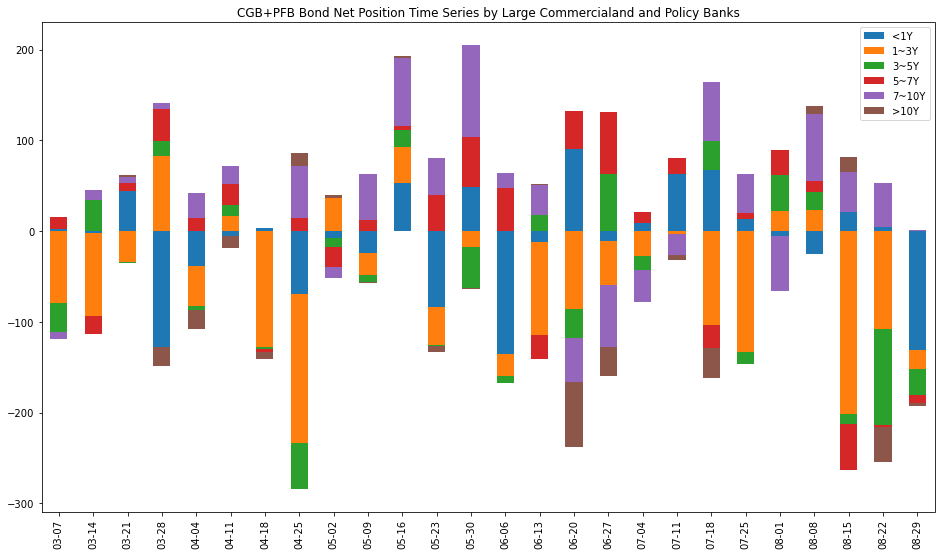

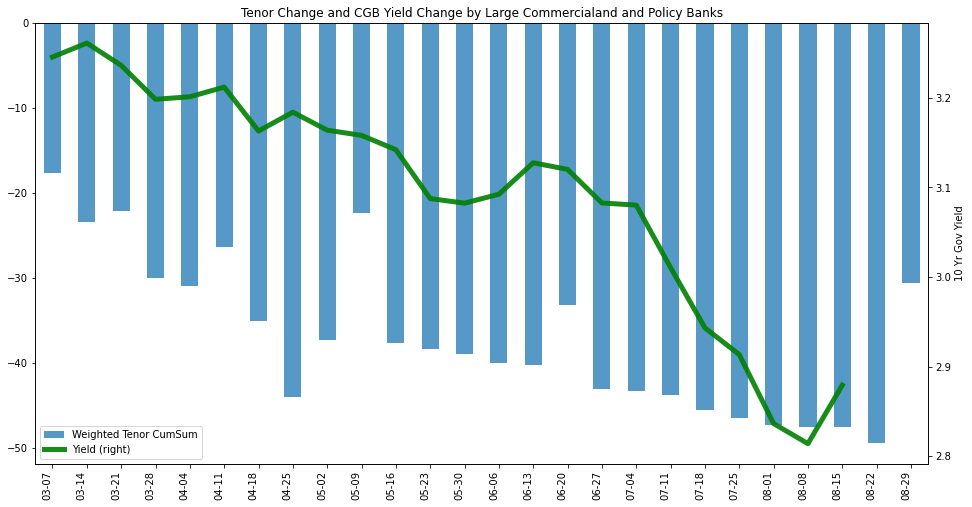

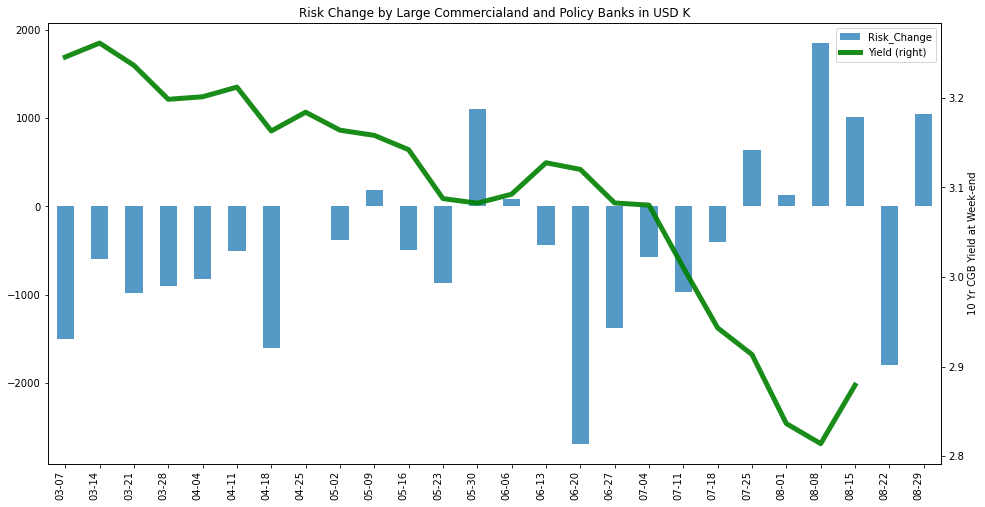

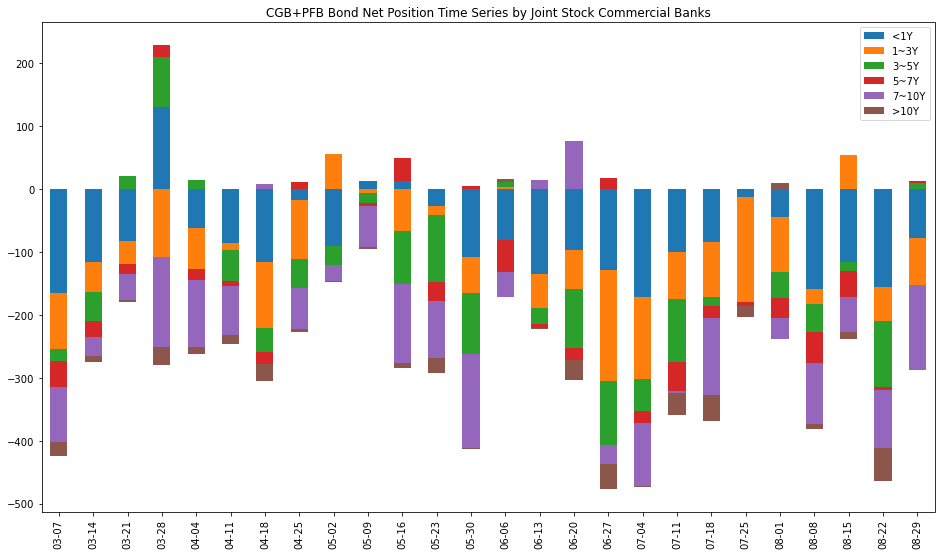

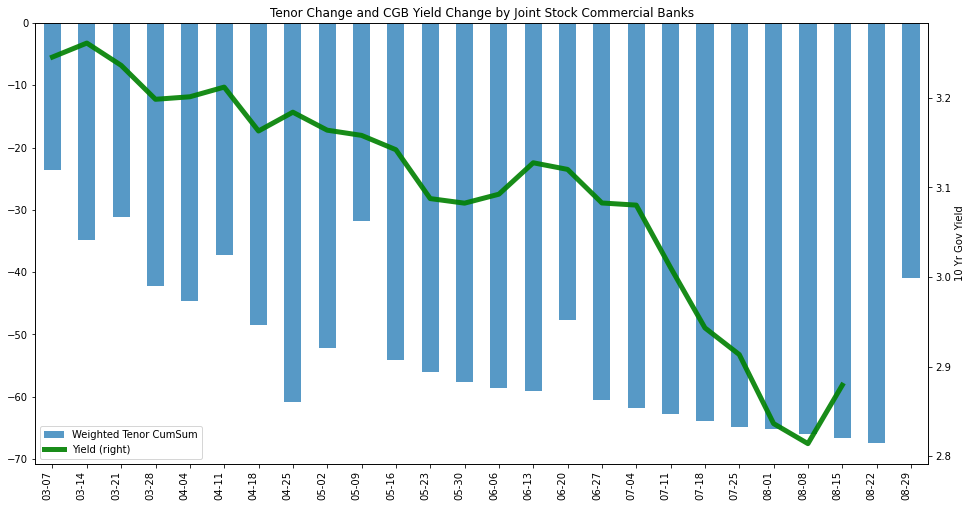

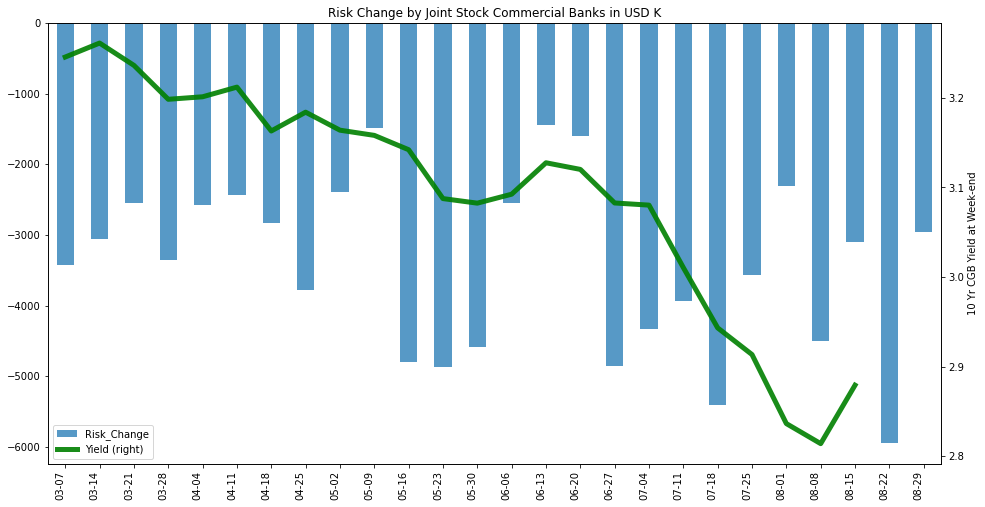

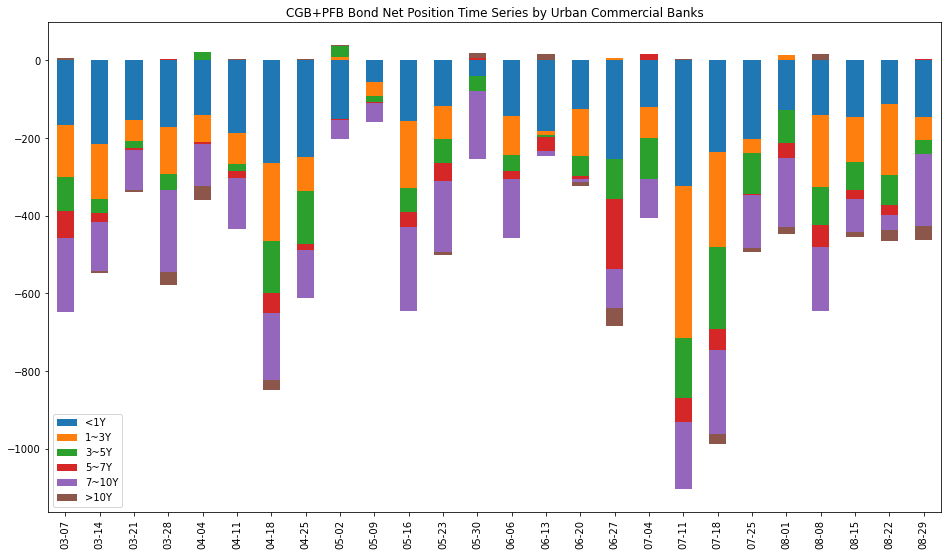

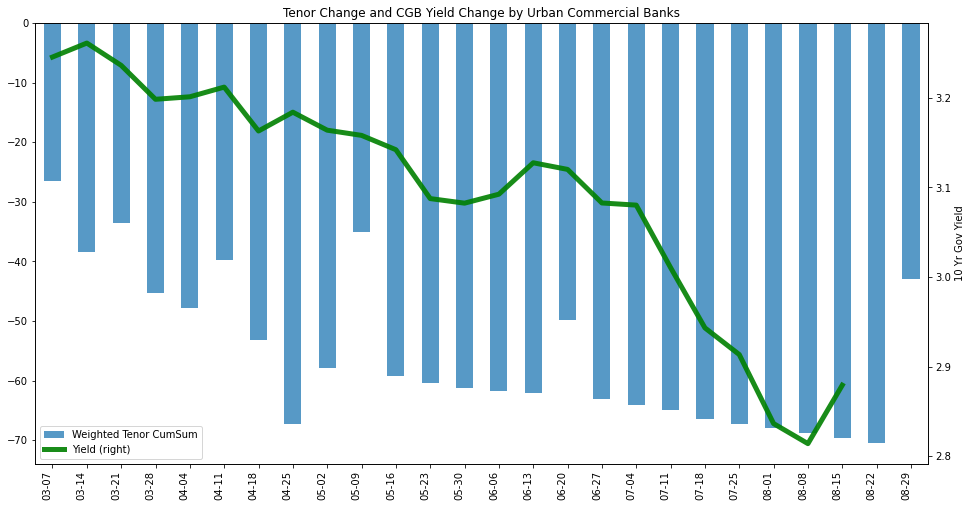

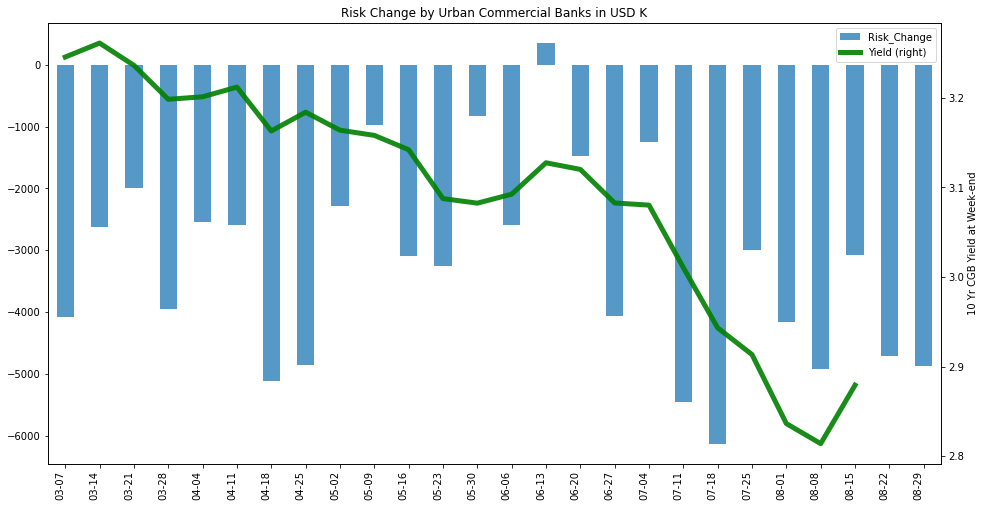

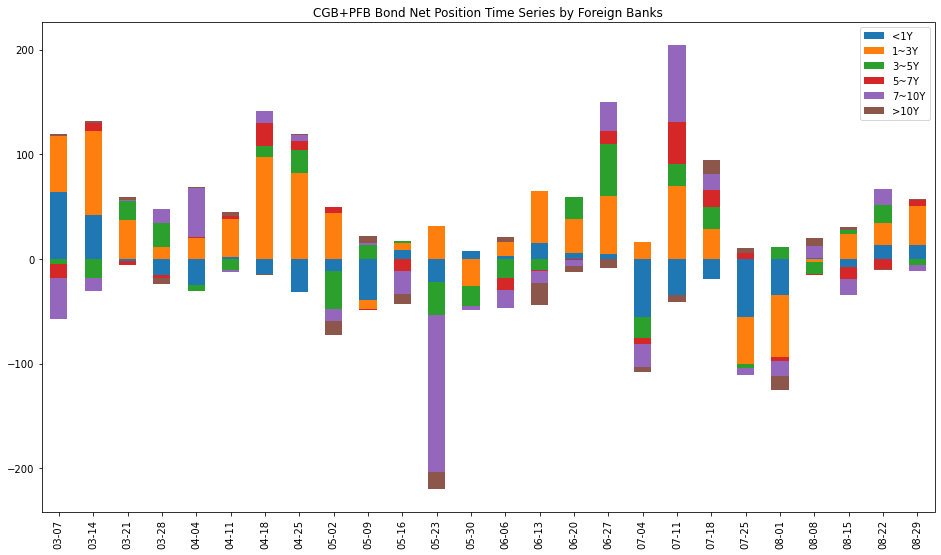

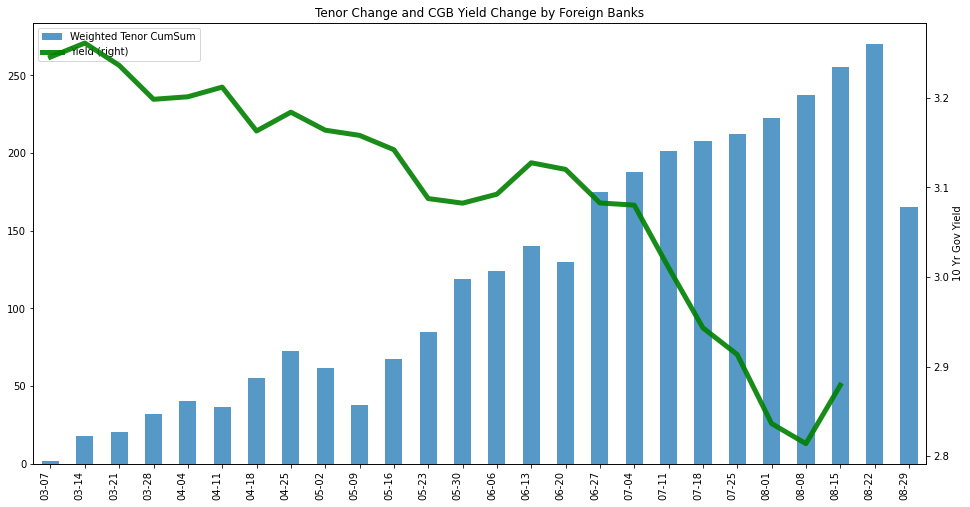

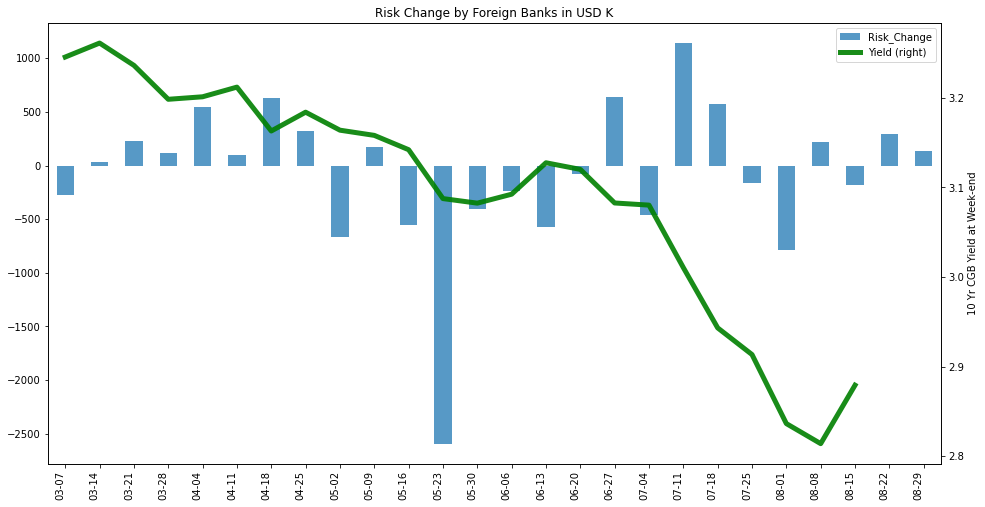

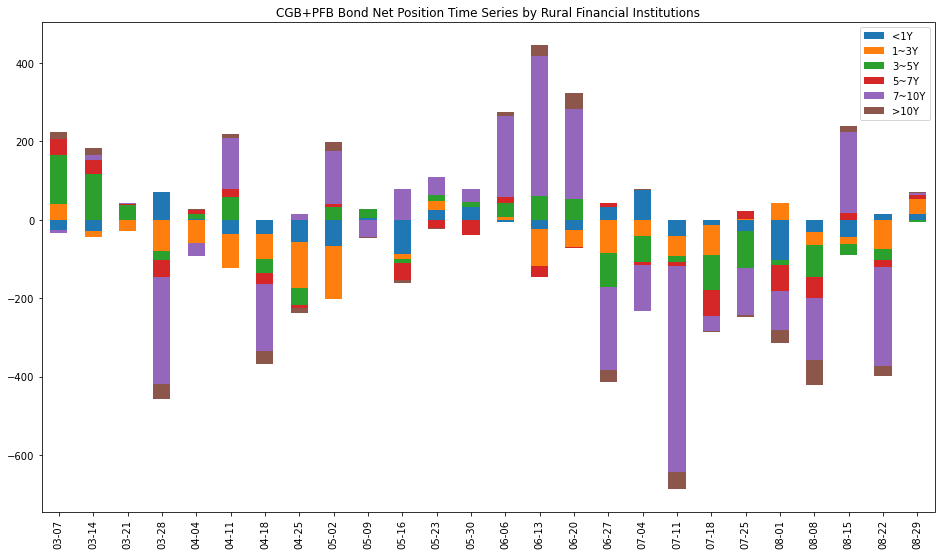

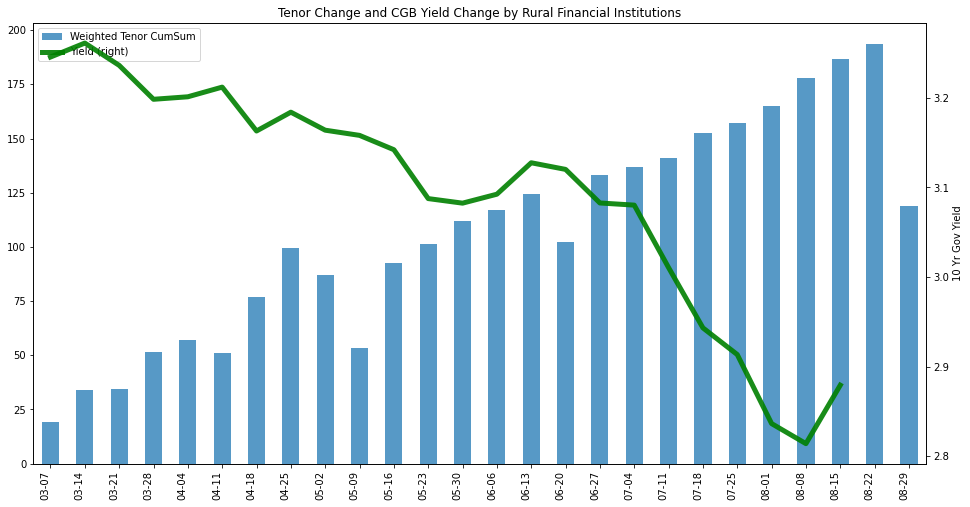

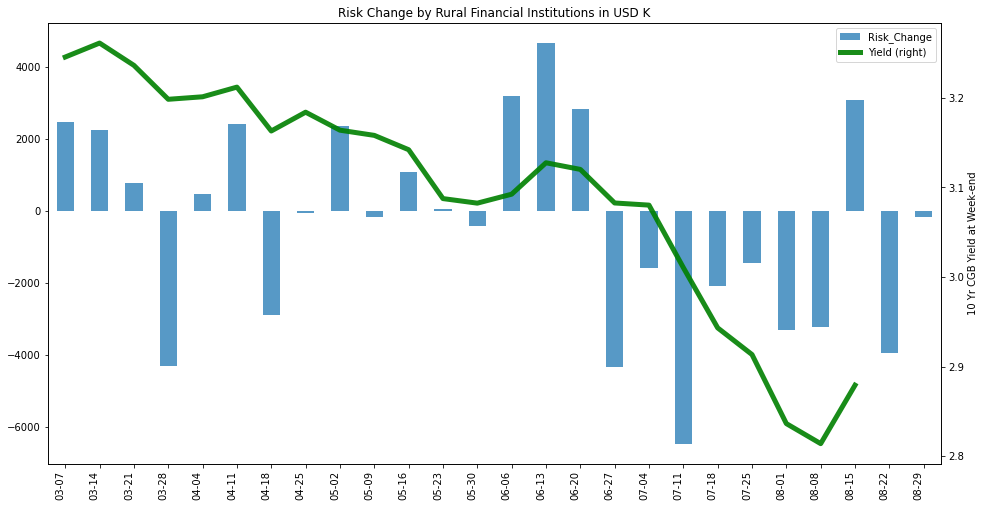

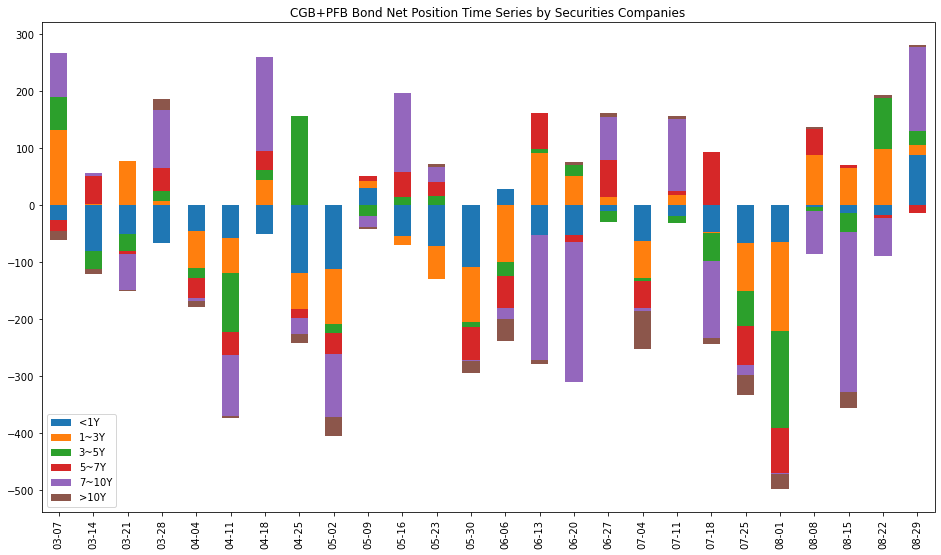

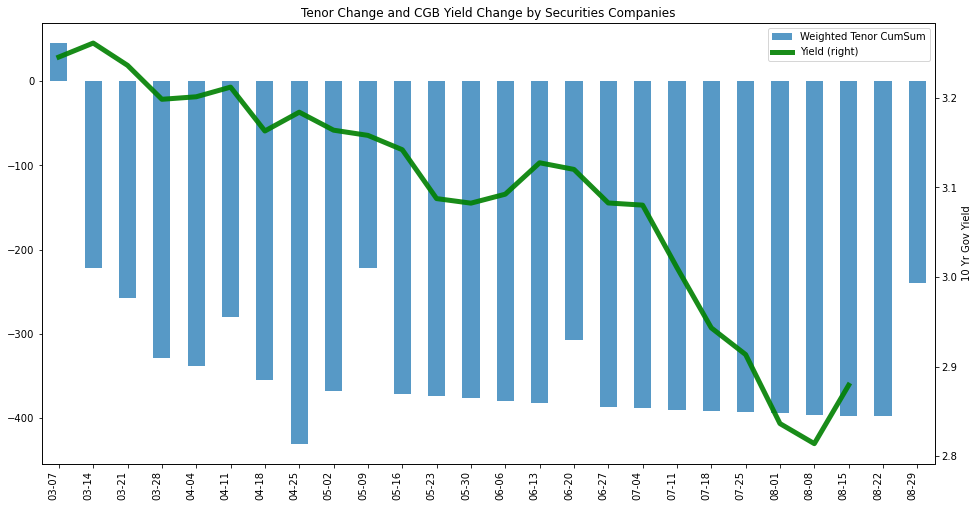

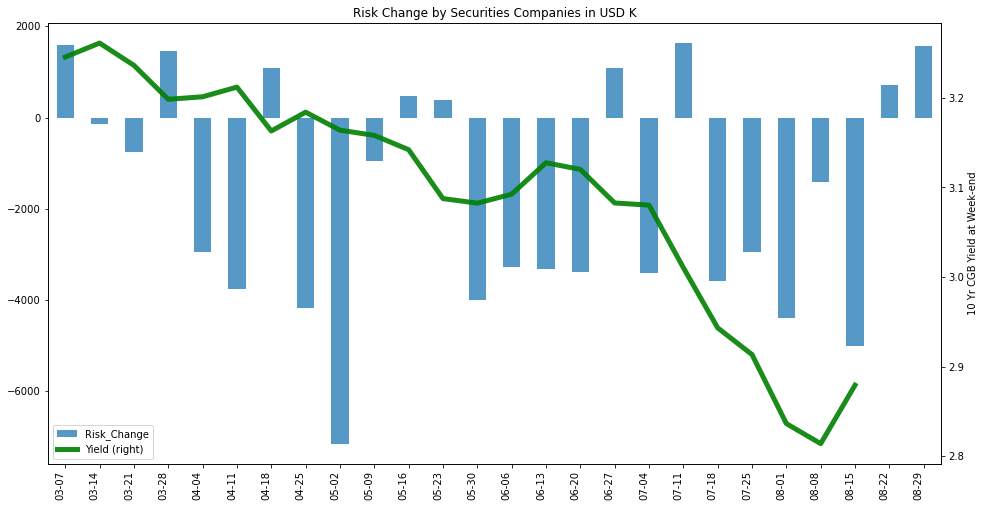

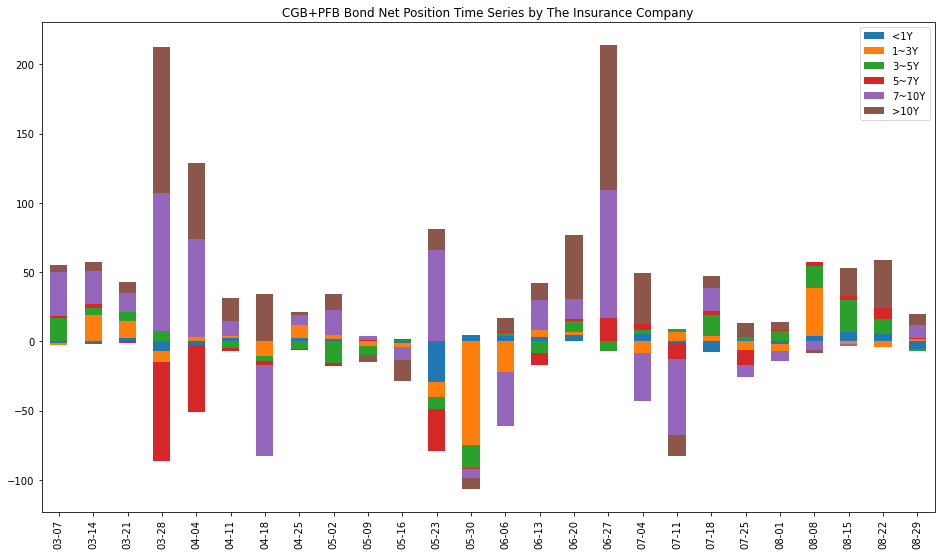

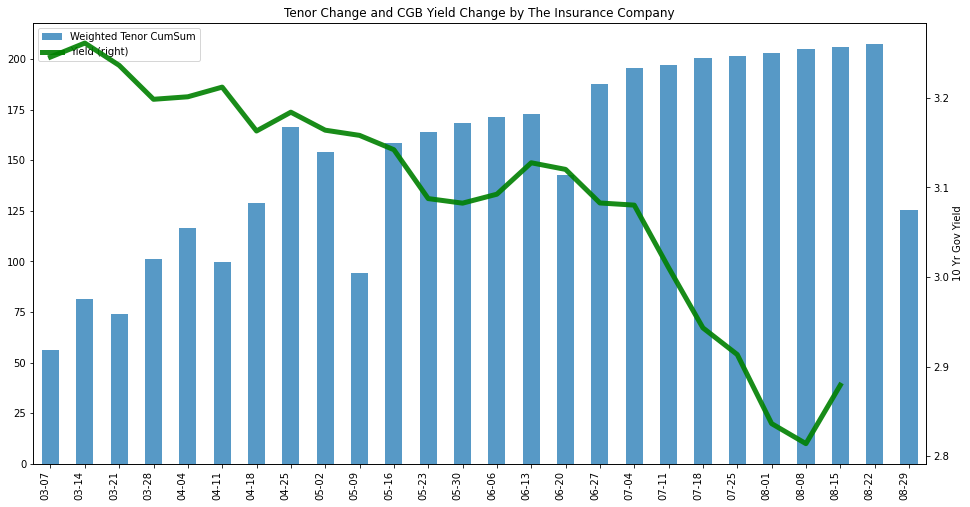

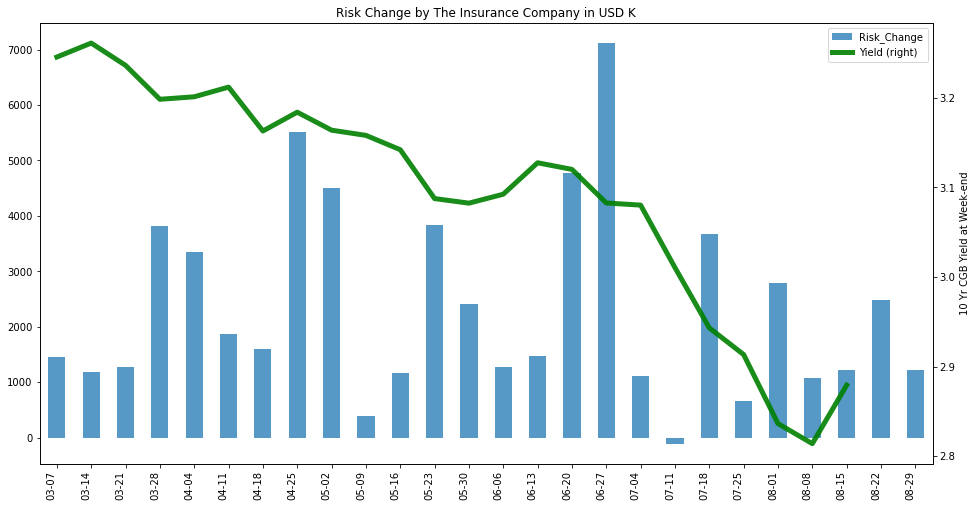

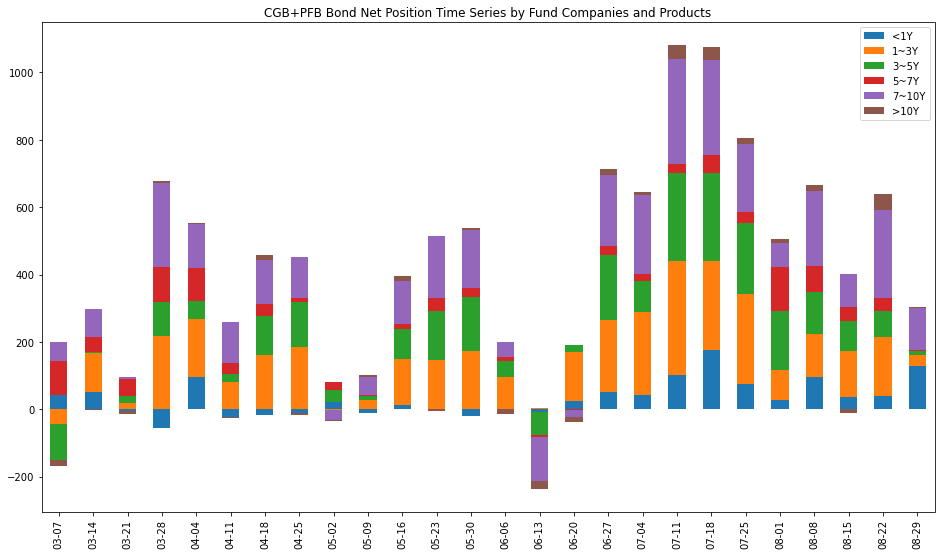

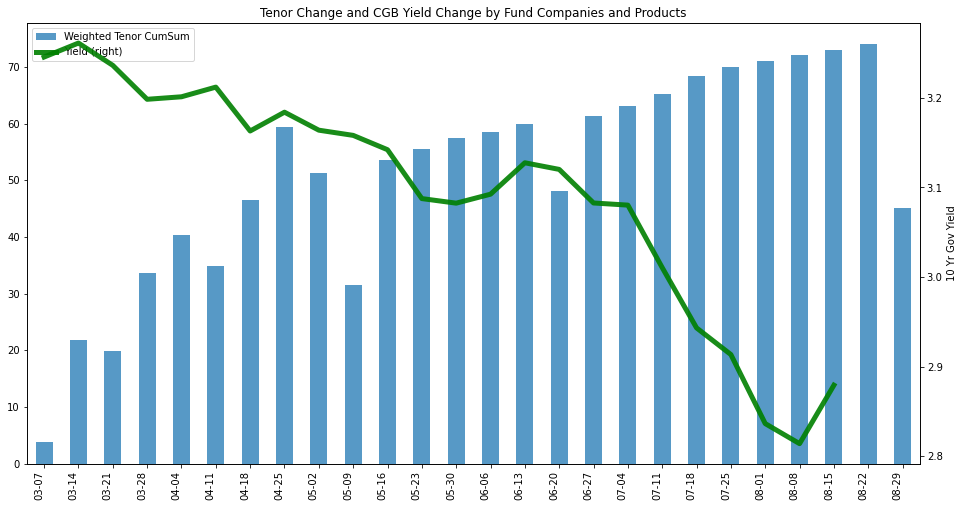

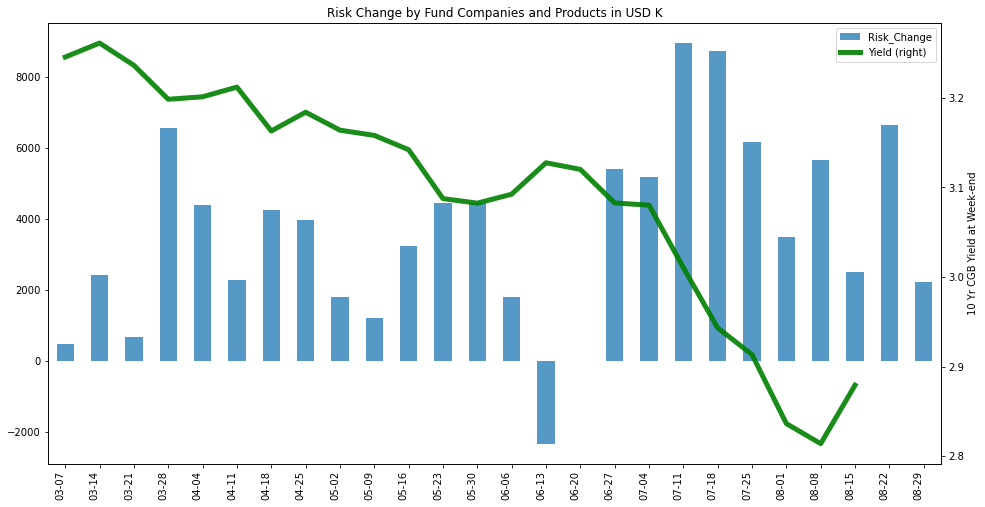

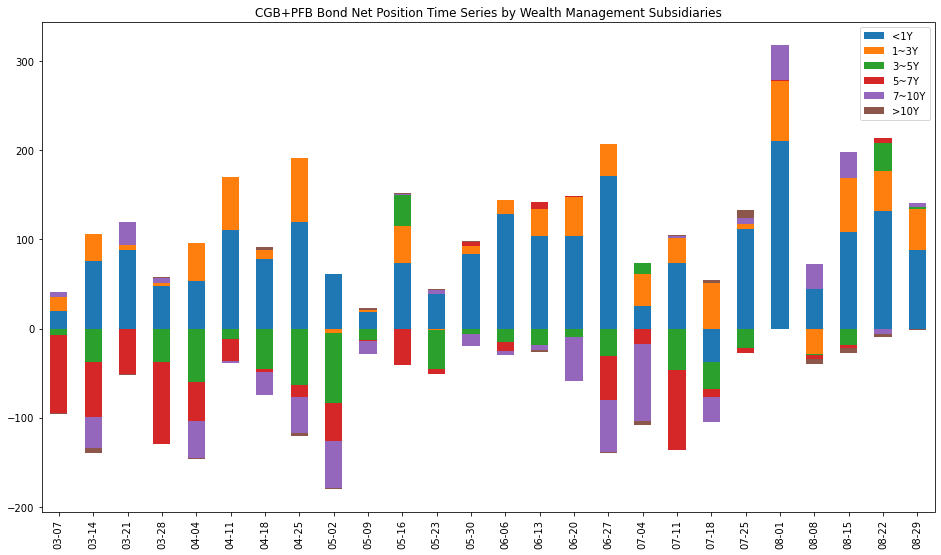

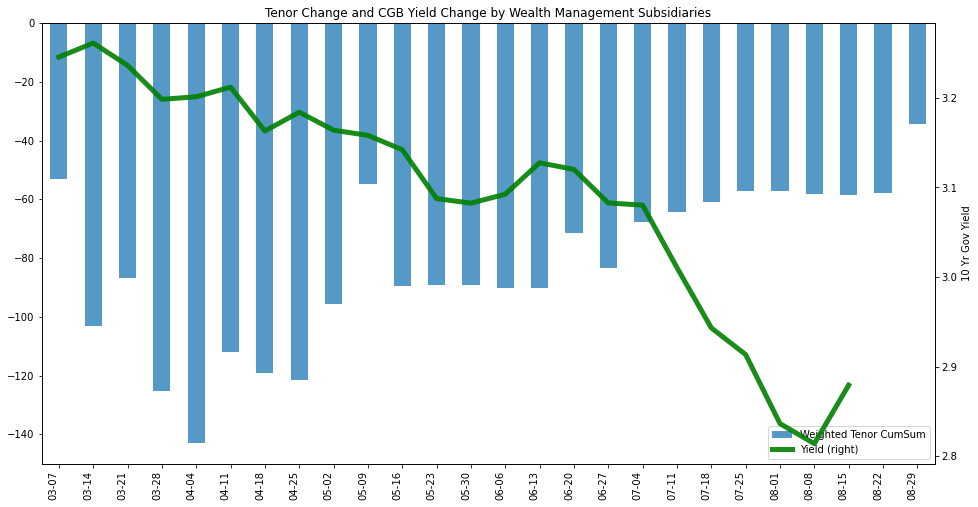

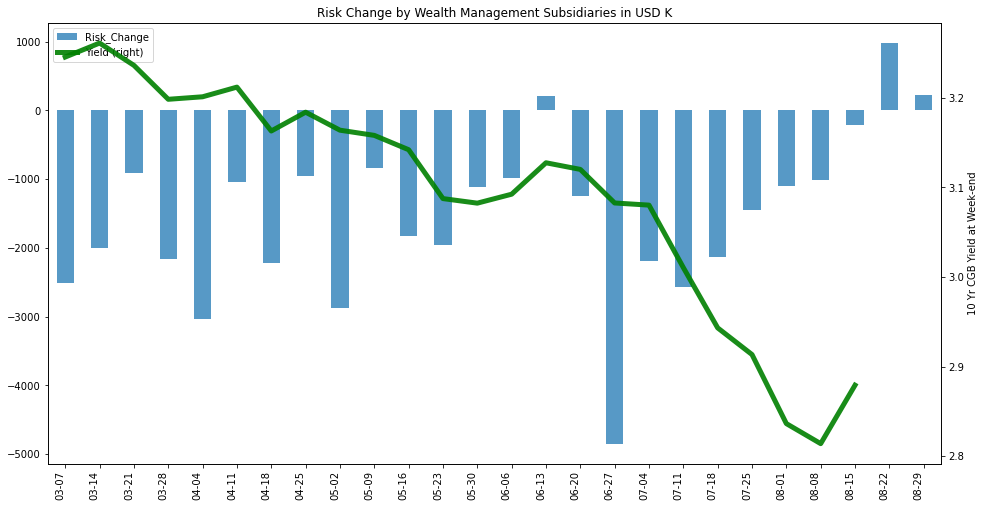

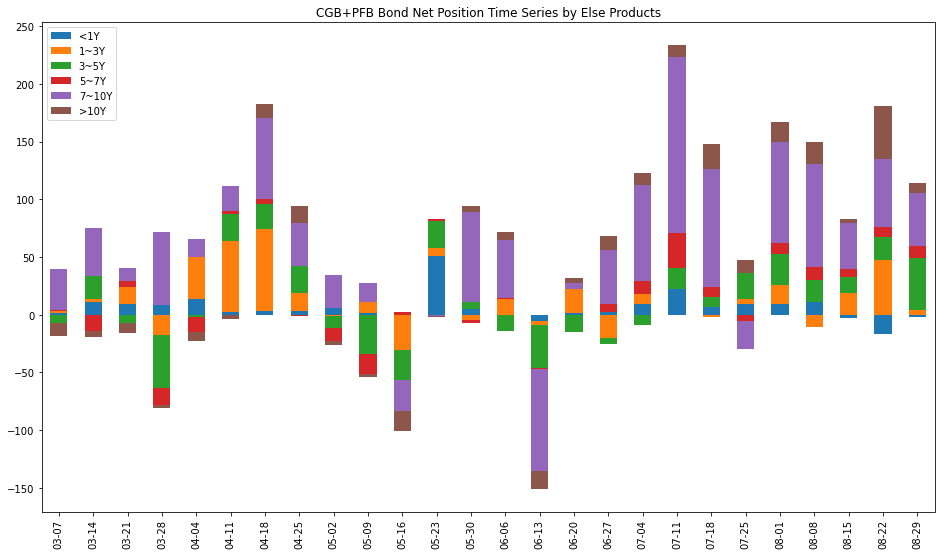

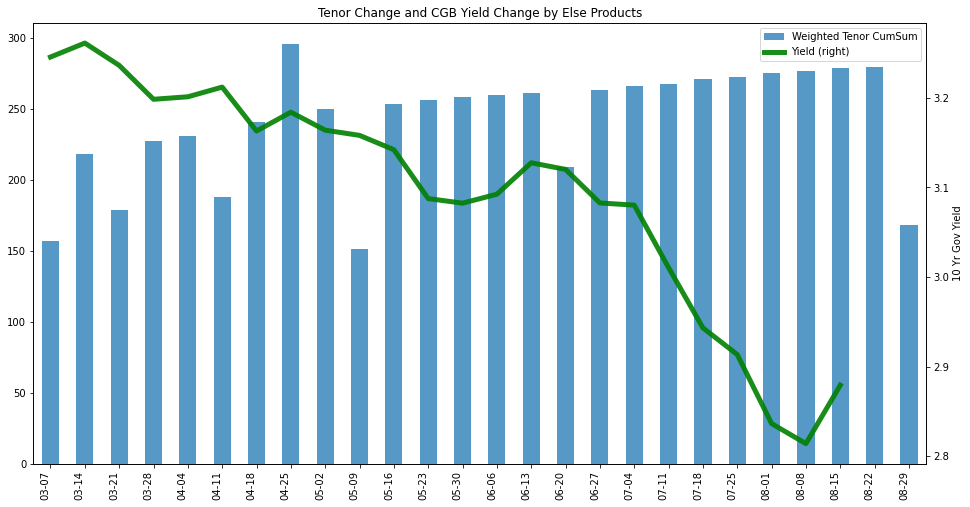

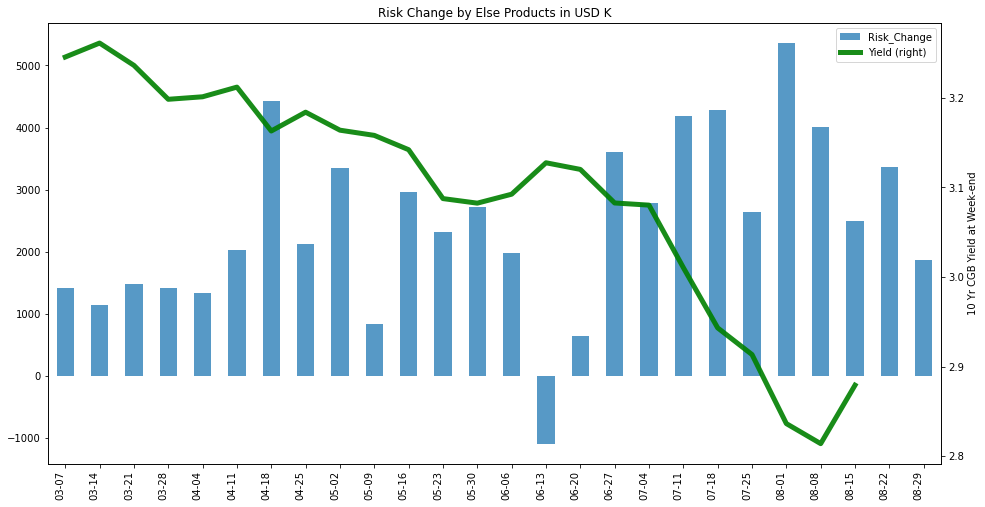

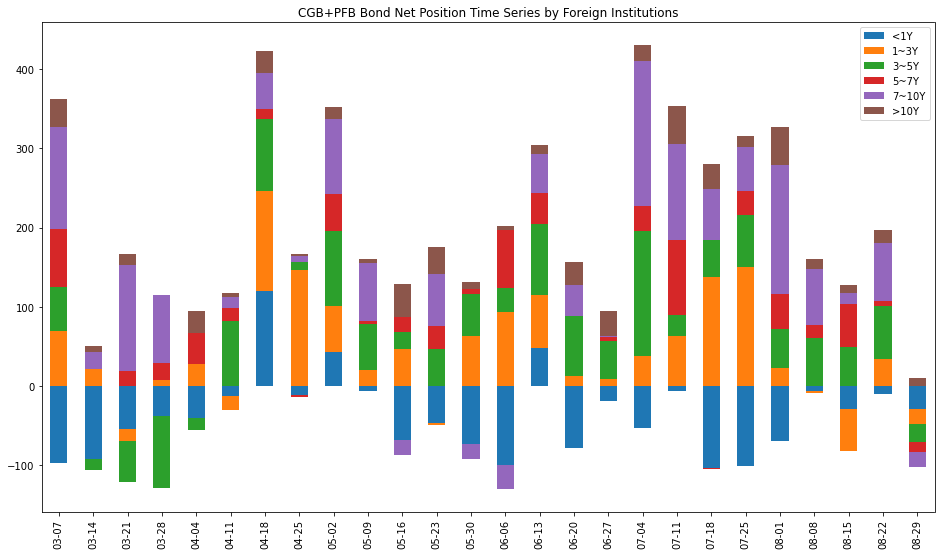

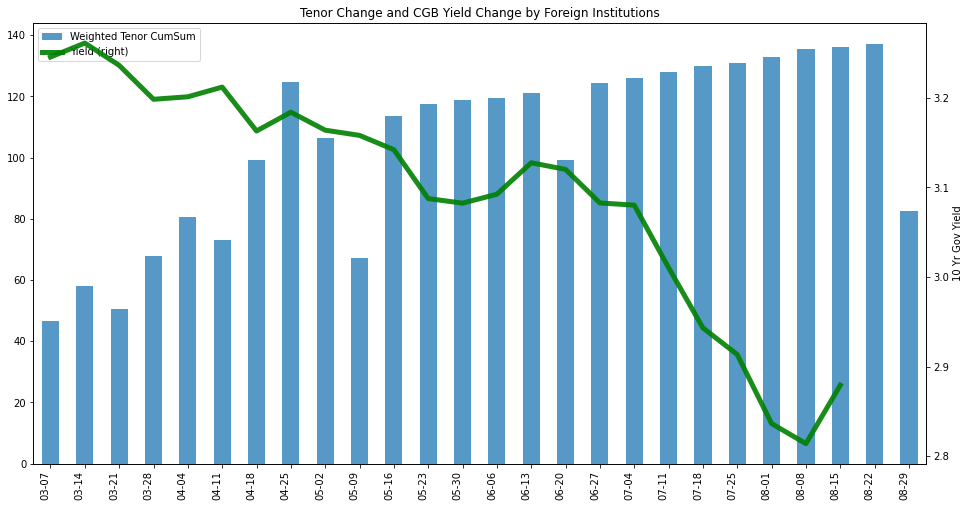

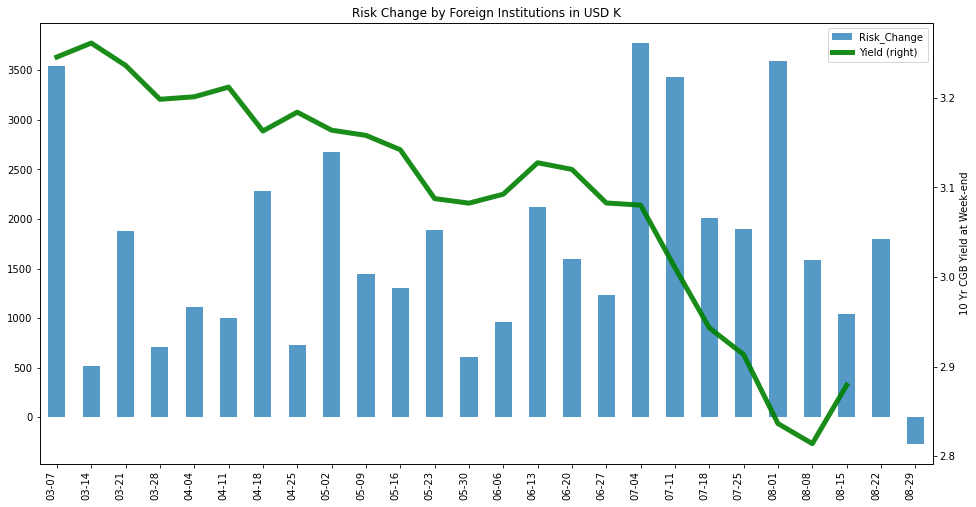

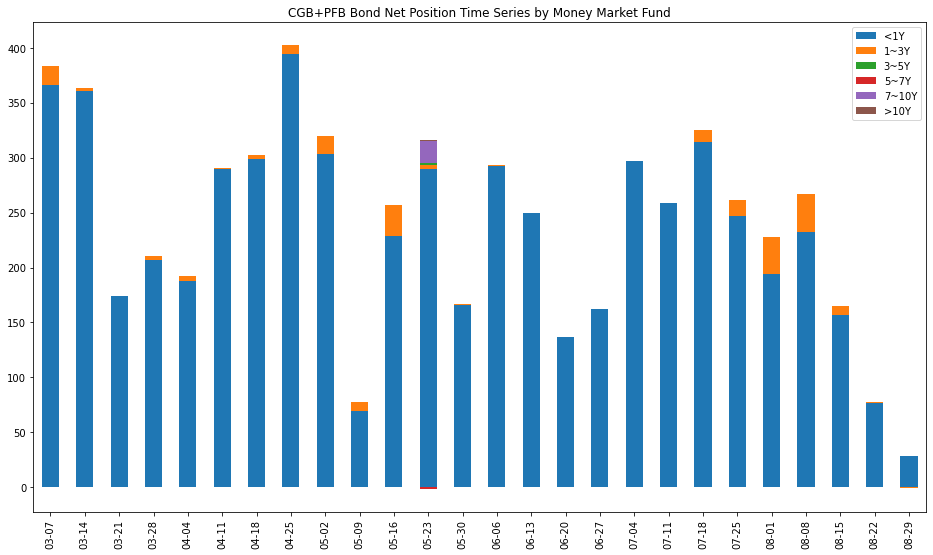

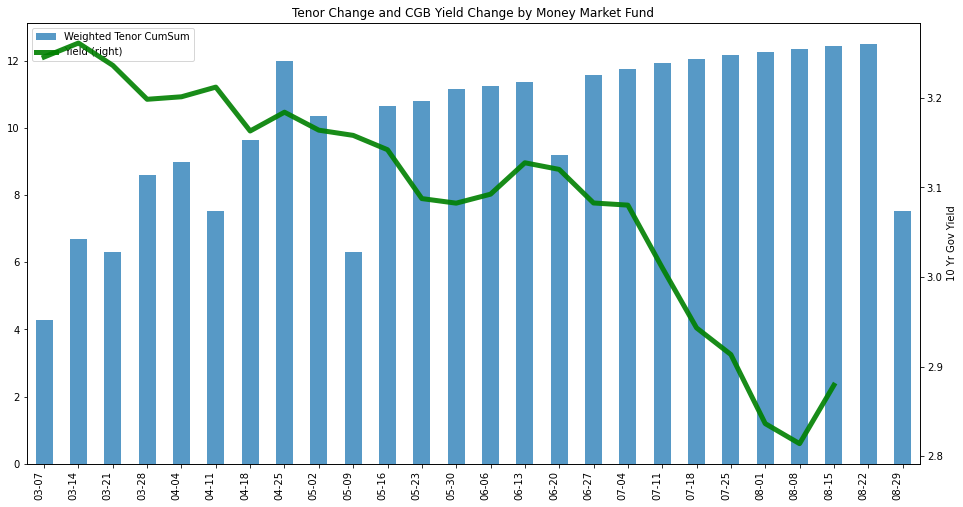

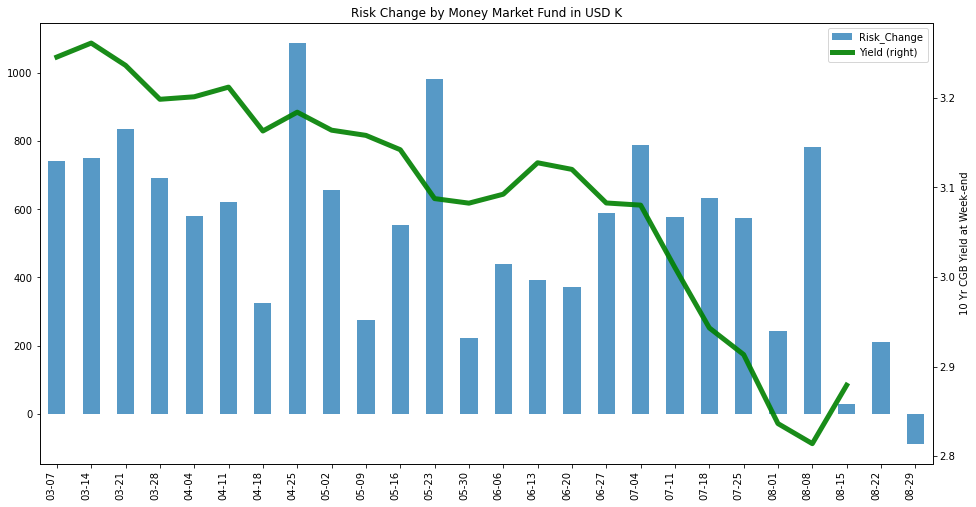

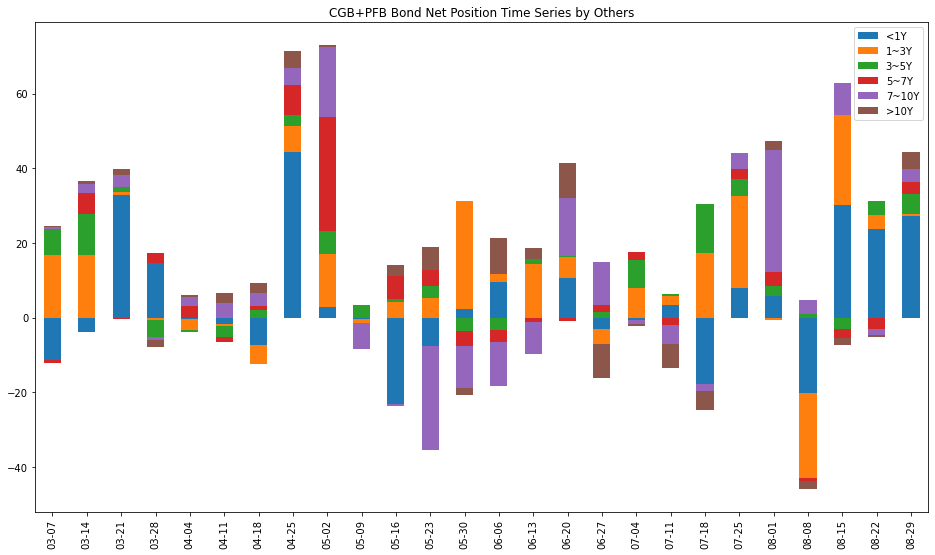

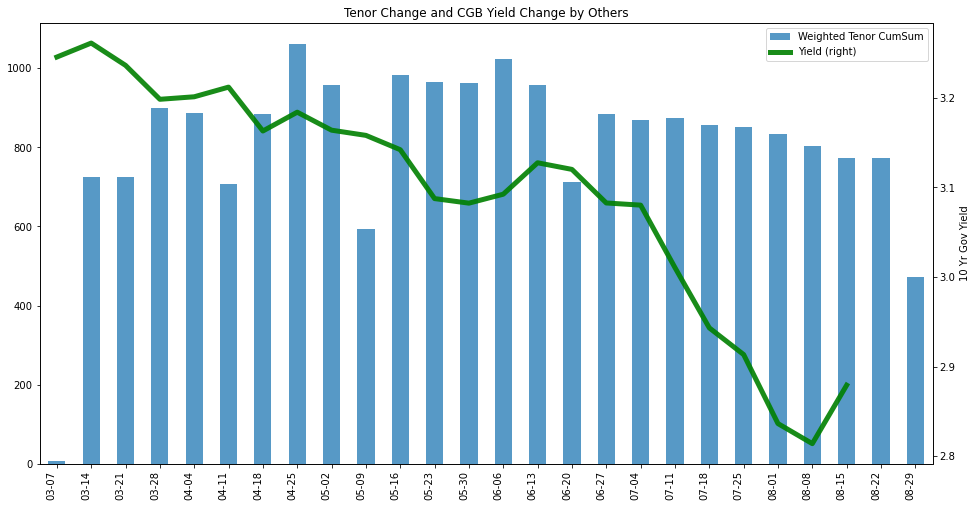

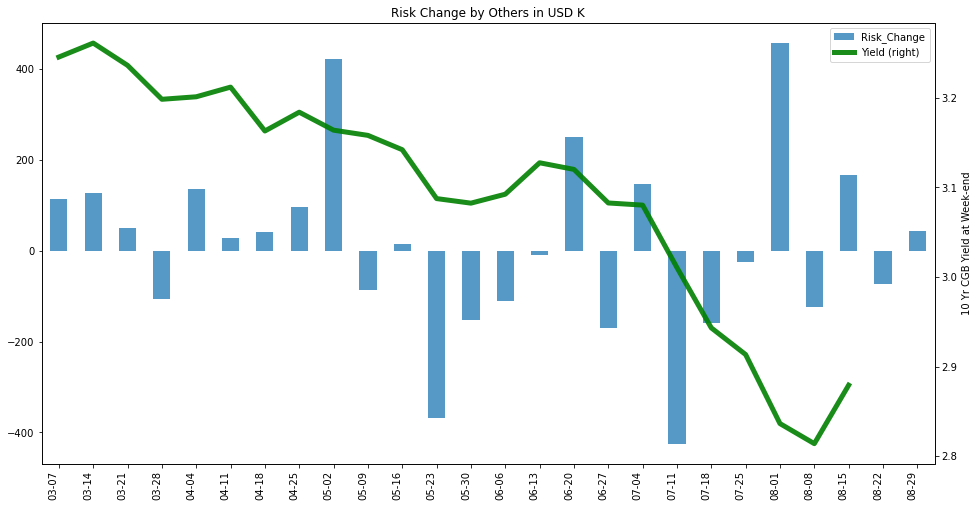

In [14]:
# ALL Institutions
def iterate_all(bond_type,start_date,maturity):
    for institution in variables_list:
        draw_cash_bond_time_series(institution[0],bond_type,start_date=start_date,name=institution[1],
                                   accumulative=False,maturity = maturity, weekly_resample=True)
        draw_tenor_with_yield(institution[0],start_date,treasury_,name=institution[1],cumsum=True,
                              pct_change=False,resample_weekly=True)
        draw_risk_change(institution[0],treasury_,start_date=start_date,name=institution[1],weekly_resample=True)

#If iterate, execute the code below
iterate_all('CGB+PFB','2021-03-01',None)

In [15]:
# End